In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.sparse import hstack

In [3]:
import networkx as nx

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, classification_report
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv("HI-Small_Trans.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [6]:
df.sample(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4615779,2022/09/09 14:17,345494,810A643E0,44873,810A53FC0,2686.34,Shekel,2686.34,Shekel,Cheque,0
5072490,2022/09/10 23:05,22,8008AEA90,5328,80B8442A0,6013.42,Euro,6013.42,Euro,Cheque,0
3431301,2022/09/07 08:53,701,8009595E0,1729,8026AD9E0,10211.43,US Dollar,10211.43,US Dollar,Cheque,0
587817,2022/09/01 08:14,3489,809765F20,4600,80B84D4F0,3110.84,Euro,3110.84,Euro,Cheque,0
3047511,2022/09/06 13:45,1124,80188F300,7042,8081B21A0,2835.43,US Dollar,2835.43,US Dollar,ACH,0


C:\Users\glaub\AppData\Local\Temp\ipykernel_8656\3669295664.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


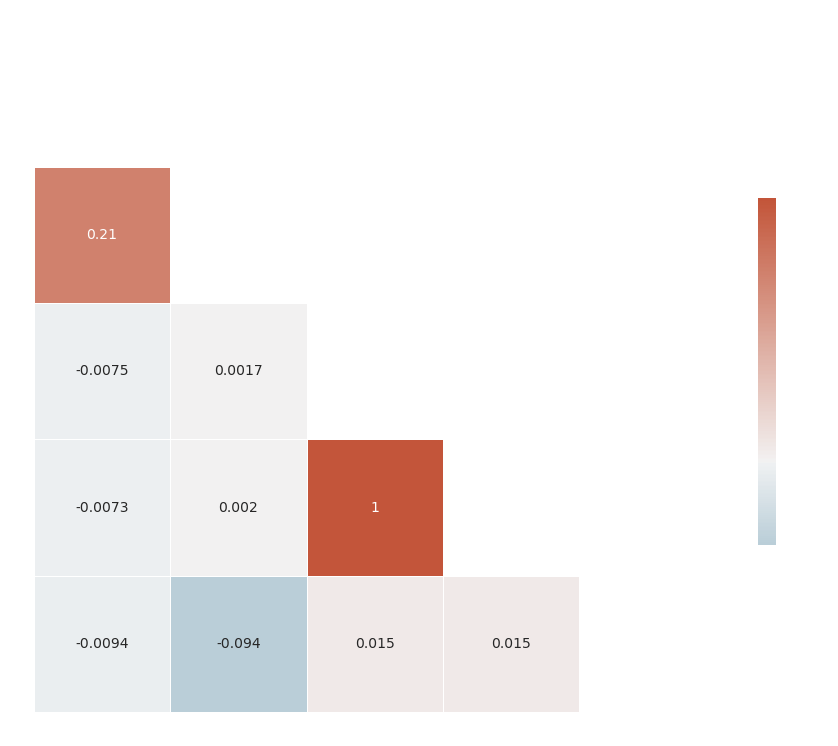

<Figure size 1800x1200 with 0 Axes>

In [12]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Correlation Heatmap')
plt.show()

plt.savefig('boxplot_age.png', transparent=True, bbox_inches='tight')


In [13]:
# downsampling the data in order that the minority is at least 20% of the dataset

from sklearn.utils import resample

# splitting the data between minority and majority classes just so we can downsample only the majority
# in order to avoid randomly taking values from the minority too

minority_class = df[df['Is Laundering'] == 1]
majority_class = df[df['Is Laundering'] == 0]


# Downsample the majority class to match the minority class size

# Set to True if you want to sample with replace

majority_downsampled = resample(majority_class, replace=False, n_samples = (len(minority_class)), random_state=42)

# combining minority_class and majority_class so we can have a balanced dataset

balanced_df = pd.concat([minority_class, majority_downsampled])

df = balanced_df

In [14]:
df.drop(['Timestamp','Account.1','Account'], axis=1, inplace=True)

KeyError: "['Timestamp', 'Account.1', 'Account'] not found in axis"

In [14]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4742,70,1124,389769.39,US Dollar,389769.39,US Dollar,Cheque,1
40621,70,11474,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1
69152,70,15980,792.92,US Dollar,792.92,US Dollar,Credit Card,1
85763,70,113798,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1
90684,70,32375,14288.83,US Dollar,14288.83,US Dollar,Cash,1


## 3 graphs showing:

1. Proportion of Transactions flagged as money laundering in Receiving Currencies

2. Proportion of Transactions flagged as money laundering in Payment Currencies

3. Proportion of types of payment flagged as money laundering

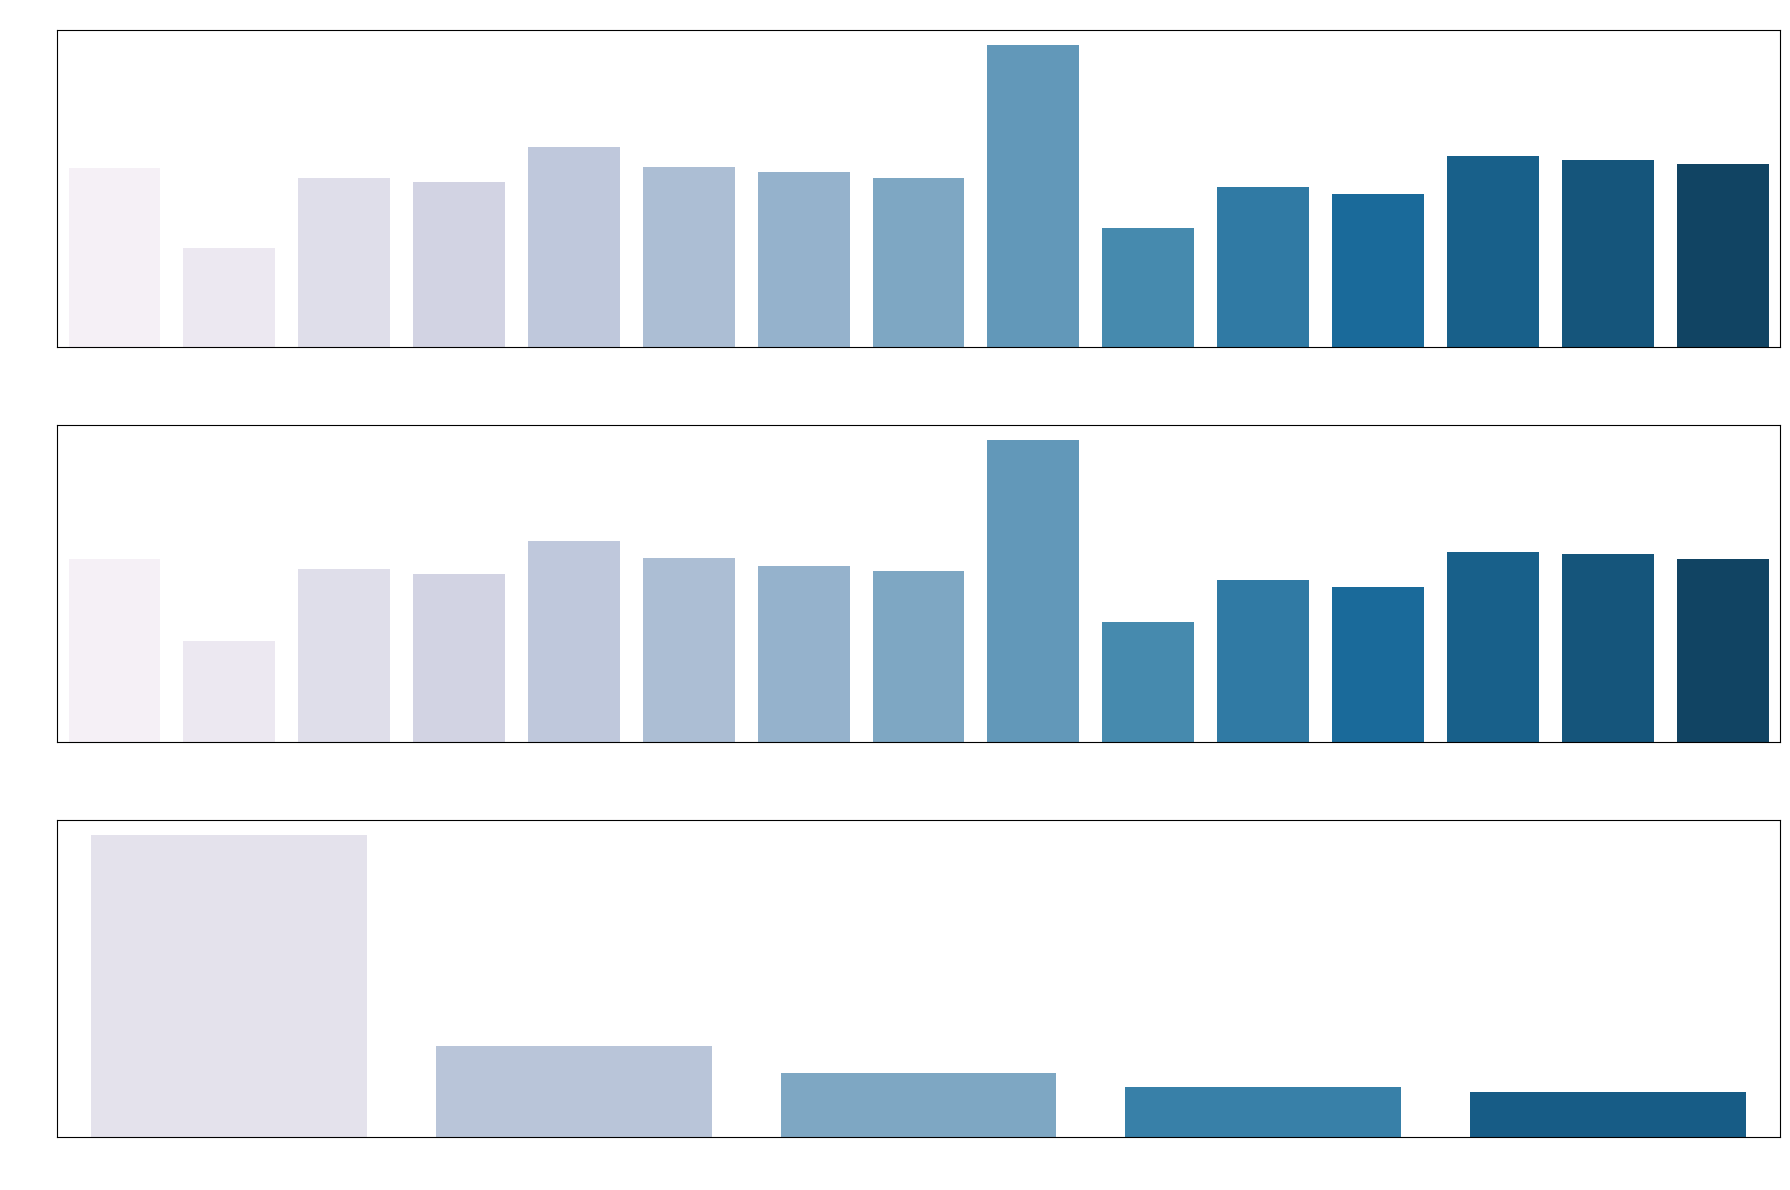

In [10]:

# Calculate the percentage of 'Is Laundering' within each category of 'Receiving Currency'
receiving_currency_grouped = df.groupby('Receiving Currency')['Is Laundering'].value_counts(normalize=True).mul(100).reset_index(name='Percentage')
receiving_currency_laundering = receiving_currency_grouped[receiving_currency_grouped['Is Laundering'] == 1]

# Calculate the percentage of 'Is Laundering' within each category of 'Payment Currency'
payment_currency_grouped = df.groupby('Payment Currency')['Is Laundering'].value_counts(normalize=True).mul(100).reset_index(name='Percentage')
payment_currency_laundering = payment_currency_grouped[payment_currency_grouped['Is Laundering'] == 1]

# Calculate the percentage of 'Is Laundering' within each category of 'Payment Format'
payment_format_grouped = df.groupby('Payment Format')['Is Laundering'].value_counts(normalize=True).mul(100).reset_index(name='Percentage')
payment_format_laundering = payment_format_grouped[payment_format_grouped['Is Laundering'] == 1]

# Set plot size for all plots
# Set plot size for all plots
plt.rcParams['figure.figsize'] = (18, 12)

# Set color to white for text and labels
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Plot the percentage of 'Is Laundering' within each category of 'Receiving Currency'
plt.subplot(3, 1, 1)
sns.barplot(x='Receiving Currency', y='Percentage', data=receiving_currency_laundering, palette='PuBu')
plt.title('Proportion of Transactions flagged as money laundering in Receiving Currencies')
plt.xlabel('Receiving Currency')
plt.ylabel('Percentage of Is Laundering')

# Plot the percentage of 'Is Laundering' within each category of 'Payment Currency'
plt.subplot(3, 1, 2)
sns.barplot(x='Payment Currency', y='Percentage', data=payment_currency_laundering, palette='PuBu')
plt.title('Proportion of types of payment flagged as money laundering')
plt.xlabel('Payment Currency')
plt.ylabel('Percentage of Is Laundering')

# Plot the percentage of 'Is Laundering' within each category of 'Payment Format'
plt.subplot(3, 1, 3)
sns.barplot(x='Payment Format', y='Percentage', data=payment_format_laundering, palette='PuBu')
plt.title('Percentage of Is Laundering within Each Payment Format')
plt.xlabel('Payment Format')
plt.ylabel('Percentage of Is Laundering')


# Adjust layout
plt.tight_layout()
plt.savefig('is_laundering_proportional_distribution.png', transparent=True, bbox_inches='tight')

plt.show()


## building the model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Separate features and target variable from data
X = df.drop('Is Laundering', axis=1)
y = df['Is Laundering']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define preprocessing for numeric and categorical data
numeric_features = ['Amount Received', 'Amount Paid']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['From Bank', 'To Bank', 'Receiving Currency', 'Payment Currency', 'Payment Format']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_test)

# Evaluate the model
score = classification_report(y_test, preds)
print(score)


              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1521
           1       0.87      0.91      0.89      1586

    accuracy                           0.88      3107
   macro avg       0.89      0.88      0.88      3107
weighted avg       0.88      0.88      0.88      3107



### F1-Score

The weighted average of Precision and Recall. It takes both false positives and false negatives into account. It is a good way to show that a classifer has a good value for both recall and precision.

This is a good score because:

Getting too many false negatives can result in:
- Compliance breaches, which in turn can lead to a substantially big fine for the banks involved and, depending on the gravity of the breach (how many shady transactions passed or how big they were) can even put the institution's licenses and operating at risk... Avoiding false negatives should definitely be the main concern for every bank and fin-tech if they want to avoid scandals, taking a big financial hits, and have problems with the law, which, ultimately can lead them to close or having to sell the company to another one.


Getting too many false positives can result in:
- Too many false positives may not lead to the worst possible scenario described above, but is not free of consequences either. Having too many false positives will increase the load in customer support, that willo perform long EDD calls with clients, receive angry clean clients' calls, complaining that had their assets are frozen or because were "expelled" as a client (Fin-techs and mostly new startups have a lower treshhold in their risk appetite and generally prefer to let go of risky clients than to keep them, as the revenue they bring might be way lower than the possible financial cost they might pose. Aside from that, the company might have to deal with minor lawsuits from these clients that were not happy with whatever resolution the company gave to how unfairly they were treated.


Because of that, I decided to balance between Precision and Recall and I chose F1-score as the metrics to evaluate my model.

`Support`: The number of actual occurrences of the class in the specified dataset.

`Accuracy`: The ratio of correctly predicted observation to the total observations. 

`Macro Avg`: The average precision, recall, or F1-score between classes. This doesn't take class imbalance into account.

`Weighted Avg`: Similar to the macro average, but this takes the class imbalance into account.

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Assume 'X' is your input feature matrix
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Get feature names
feature_names = encoder.get_feature_names_out()

In [18]:
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df[['From Bank', 'To Bank']])

# Get feature names
feature_names = encoder.get_feature_names_out(['From Bank', 'To Bank'])
print(feature_names)


['From Bank_1' 'From Bank_3' 'From Bank_4' ... 'To Bank_343239'
 'To Bank_345219' 'To Bank_354221']


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [ ]:
df.columns

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Amount Received', 'Amount Paid']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['From Bank', 'To Bank', 'Receiving Currency', 'Payment Currency', 'Payment Format'])
    ])

# Define classifiers
classifiers = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB()
]
# Iterate over classifiers
for classifier in classifiers:
    # Create and evaluate the pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])
    
    # Maybe use GridSearchCV or RandomizedSearchCV to tune hyperparameters
    grid = GridSearchCV(pipe, param_grid={}, cv=5, scoring='f1_macro')  # Adjust param_grid as needed
    grid.fit(X_train[:10], y_train[:10])
    print(f'Model: {classifier}')
    print(f'Train accuracy: {grid.best_score_}')
    print(f'Test accuracy: {grid.score(X_test, y_test)}')
    print()


NameError: name 'DecisionTreeClassifier' is not defined

## hyperparameter tuning

1. Support Vector Classifier (SVC)
For SVC, important hyperparameters include:

C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
kernel: Specifies the kernel type to be used in the algorithm (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’).
degree: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
gamma: Kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’.

2. Random Forest Classifier
For RandomForestClassifier, important hyperparameters include:

n_estimators: The number of trees in the forest.
max_depth: The maximum depth of the tree.
min_samples_split: The minimum number of samples required to split an internal node.
min_samples_leaf: The minimum number of samples required to be at a leaf node.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
} 

# Create and evaluate the pipeline
svc_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC())])

grid_search_svc = GridSearchCV(svc_pipe, param_grid, cv=5, )
grid_search_svc.fit(X_train, y_train)